# Проект для «Amazon» с BERT

Интернет-магазин «Amazon» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Нужно обучить модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Загрузка данных

In [6]:
# Скачиваем нужные библиотеки
!pip install pymystem3
!pip install hf_xet
!pip install wordcloud

In [7]:
# Подключаем нужные библиотеки
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import transformers
from tqdm import notebook 
from pymystem3 import Mystem
import re
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import warnings
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.feature_extraction.text import TfidfTransformer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# Вводим нужные константы
warnings.filterwarnings("ignore")
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('averaged_perceptron_tagger')
RANDOM_STATE = 42

In [12]:
df_tox_com = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)

In [13]:
# Создадим функцию, для отображения нужной информации о датафрейме
def df_info(df):
    display(df.head(10))
    df.info()
    display(df.describe())

In [14]:
# Отобразим информацию о df_taxi
df_info(df_tox_com)

После загрузки необходимых файлов, имеем 1 датафрейм и 2 уникальных столбца с данными.

В датафрейме `df_tox_com` мы сохранили набор данных с разметкой о токсичности правок.

**Описание данных:**
1. text — текст комментария
2. toxic — токсичность комментария (0 - не токсичный, 1 - токсичный)

Необходимо будет заменить тип данных у столбца `toxic` для экономии памяти.

## Предобработка данных

### Выставление корректных типов данных

**Преобразуем тип данных int 64 в int 32 для экономии памяти в столбцах:**
- `toxic`

In [24]:
df_tox_com['toxic'] = df_tox_com['toxic'].astype('int32')

### Удаление пропусков

**Определим кол-во пропусков в каждом столбце**

In [27]:
df_tox_com.isna().sum()

Пропуски не обнаружены

### Обработка дубликатов

**Найдем явные дубликаты**

In [31]:
# Найдем явные дубликаты
print(df_tox_com.duplicated().sum())

Явные дубликаты не найдены.

На этапе предобработки данных, нам удалось:
1. Проверить данные на наличие пропусков
2. Выставить корректные типы данных для экономии памяти
3. Проверить данные на наличие дубликатов

## Исследовательский анализ данных

In [37]:
# Создадим функцию для отображения качественных признаков в форме пирога
def qual_feat_pie(df, col, title, label):
    # Отобразим данные в столбце col
    display(df[col].value_counts())
    
    # Отобразим гистограмму, построенную для столбца col
    plt.title(title, loc='center', pad=125)
    plt.pie(df[col].value_counts(), labels=[*label], autopct='%1.1f%%', radius=1);

### Изучим и опишем данные из таблицы df_tox_com

**Изучим столбец `toxic`**

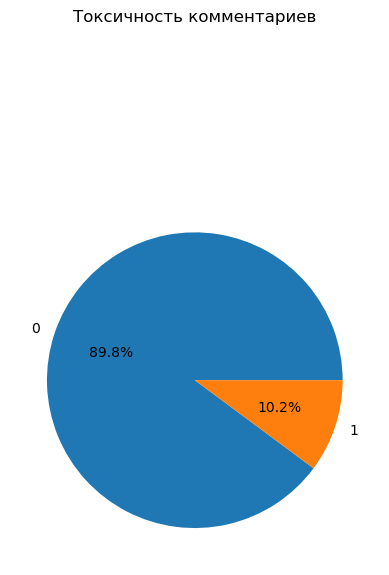

In [40]:
# Построим круговую диаграмму для стоблца toxic
qual_feat_pie(df_tox_com, 'toxic', 'Токсичность комментариев', ['0', '1'])

На этапе исследовательского анализа данных, нам удалось:
1. Изучили и описали данные из таблицы df_tox_com

По полученым данным, можно сказать:
- 90% комментариев не являются токсичными

## Обучение моделей без использования BERT

### Подготовим данные

**Выполним преобработку текста**

In [49]:
# Создадим класс для лемматизации
lemmatizer = WordNetLemmatizer()

In [50]:
# Зададим стоп слова
stop_words = set(stopwords.words('english'))

In [51]:
# Новый код
# Создадим функцию для POS-тегирования (пометки частей речи)
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [52]:
# Создадим функцию для очистки и лемматизации текста
def clear_lemmatize(text):
    # Избавимся от лишних символов
    text = re.sub(r'[^a-zA-Z \n]',' ',text.lower())
    text = text.split()
    text = " ".join(text)
    
    # Новый код
    # Произведем лемматизацию текста
    # Токенизируем предложение и найдем POS-тег для каждого токена
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))
    # С помощью функции pos_tagger преобразуем POS-теги так, чтобы они были понятны для WordNetLemmatizer
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_text = []
    for word, tag in wordnet_tagged:
        if tag is None:
        # Если доступного тега нет, добавим токен как есть
            lemmatized_text.append(word)
        else:        
        # Иначе, используем тег для лемматизации токена
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    lemm_text = " ".join(lemmatized_text)

    #Старый код
    # list_with_words = nltk.word_tokenize(text)
    # for word in list_with_words:
    #     initial_word = lemmatizer.lemmatize(word)
    #     lemmatized_text.append(initial_word)
    
    
    return lemm_text

In [55]:
%%time
df_tox_com['lemm_text'] = df_tox_com['text'].apply(clear_lemmatize)
df_tox_com = df_tox_com.reset_index(drop=True)

In [56]:
df_tox_com['lemm_text'].head(10)

**Посторим облако слов**

In [58]:
# Новый код
# Выделим токсичные тексты для построения облака слов
text_row_tox = df_tox_com.query('toxic == 1')['lemm_text']
text_row_tox = " ".join(text_row_tox)

In [59]:
# Новый код
# Выделим нетоксичные тексты для построения облака слов
text_row_not_tox = df_tox_com.query('toxic != 1')['lemm_text']
text_row_not_tox = " ".join(text_row_not_tox)

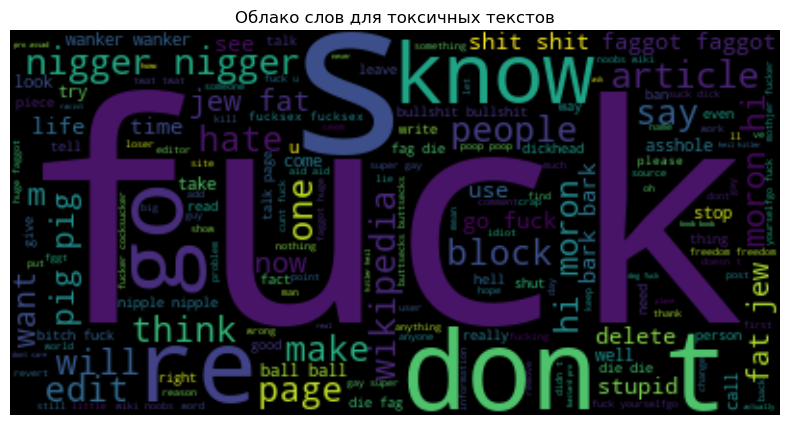

In [60]:
%%time
# Посторим облако слов для токсичных текстов
wordcloud = WordCloud().generate(text_row_tox)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для токсичных текстов')
plt.show()

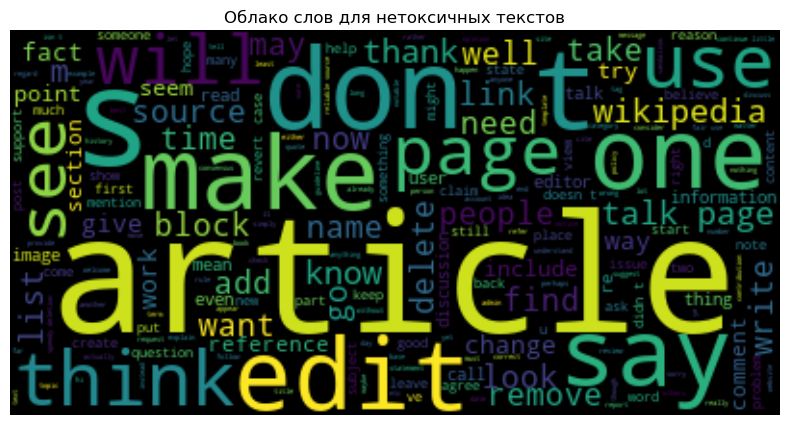

In [61]:
%%time
# Посторим облако слов для нетоксичных текстов
wordcloud = WordCloud().generate(text_row_not_tox)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для нетоксичных текстов')
plt.show()

**Проанализируем частоту слов**

In [64]:
%%time
# Токенизируем токсичные тексты
text_tokens_tox = word_tokenize(text_row_tox)
text_tox = nltk.Text(text_tokens_tox)
fdist = FreqDist(text_tox)

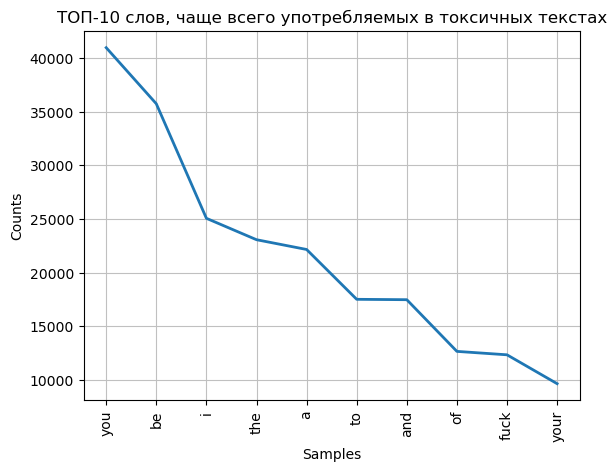

In [65]:
# Построим график частотности слов в токсичных текстах
plt.title('ТОП-10 слов, чаще всего употребляемых в токсичных текстах')
plt.xlabel('Слова')
plt.ylabel('Частота')
fdist.plot(10,cumulative=False)
plt.show()

In [66]:
%%time
# Токенизируем нетоксичные тексты
text_tokens_not_tox = word_tokenize(text_row_not_tox)
text_not_tox = nltk.Text(text_tokens_not_tox)
fdist = FreqDist(text_not_tox)

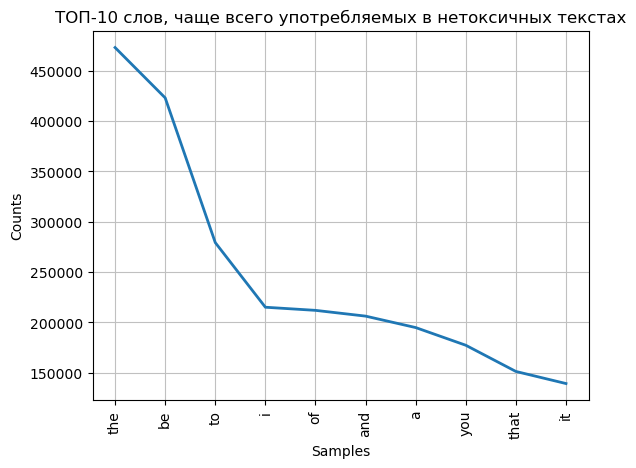

In [67]:
# Построим график частотности слов в нетоксичных текстах
plt.title('ТОП-10 слов, чаще всего употребляемых в нетоксичных текстах')
plt.xlabel('Слова')
plt.ylabel('Частота')
fdist.plot(10,cumulative=False)
plt.show()

**Разобьем выборки на тренировочные, валидационные и тестовые**

In [71]:
# Старый код
# # Создадим счётчик
# count_vect = CountVectorizer(stop_words=list(stop_words))
# # Передадим счётчику корпус текстов
# bow = count_vect.fit_transform(df_tox_com['lemm_text'])

In [72]:
# Разабьем данные на обучающие и тестовые
data_train, data_test = train_test_split(
    df_tox_com,
    test_size=0.25,
    random_state=RANDOM_STATE)

In [73]:
# Новый код
# Разабьем данные на обучающие и валидационные
data_train, data_valid = train_test_split(
    data_train,
    test_size=0.25,
    random_state=RANDOM_STATE)

In [74]:
# Старый код
# Создадим корпусы текстов для обучающей и тестовой выборки
# corpus_train = data_train['lemm_text'].values.astype('U')
# corpus_test = data_test['lemm_text'].values.astype('U')

In [75]:
# Новый код
# Создадим корпусы текстов для обучающей, валидационной и тестовой выборки
corpus_train = data_train['lemm_text'].values
corpus_valid = data_valid['lemm_text'].values
corpus_test = data_test['lemm_text'].values

In [78]:
# Старый код
# # Создадим счетчик для TF-IDF
# count_tf_idf = TfidfVectorizer(stop_words=list(stop_words))

# # Посчитаем TF-IDF для корпуса текстов
# tf_idf_train = count_tf_idf.fit_transform(corpus_train)
# tf_idf_valid = count_tf_idf.transform(corpus_valid)
# tf_idf_test = count_tf_idf.transform(corpus_test)

**Разобьем данные на обучающие, валидационные и тестовые**

In [80]:
# Старый код
# X_train = tf_idf_train
# y_train = data_train['toxic']
# X_valid = tf_idf_valid
# y_valid = data_valid['toxic']
# X_test = tf_idf_test
# y_test = data_test['toxic']

In [81]:
# Новый код
X_train = corpus_train
y_train = data_train['toxic']
X_valid = corpus_valid
y_valid = data_valid['toxic']
X_test = corpus_test
y_test = data_test['toxic']

# Вывод необходимых размерностей
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

### Сделаем прогноз без изменения баланса классов

**Подготовим пайплайн**

In [86]:
# Старый код
# # Создаём итоговый пайплайн: подготовка данных и модель
# pipe_final = Pipeline([
#     ('models', LogisticRegression(random_state=RANDOM_STATE)) 
# ])

In [201]:
# Новый код
# Создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('vect', CountVectorizer(stop_words=list(stop_words))),
    ('tfidf', TfidfTransformer()),
    ('models', LogisticRegression(random_state=RANDOM_STATE)) 
])

### Обучим четыре модели

In [203]:
# В списке словарей укажем, какие модели и какие варианты масштабирования собираемся перебрать
param_grid = [
     # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2, 7)
    },
    
    #словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 7)   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1',
            class_weight='balanced'
        )],
        'models__C': range(1, 7)
    },
    
    # словарь для модели SVC()
    {
        'models': [LinearSVC(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__C': np.arange(0.1, 1, 0.1)
    }
]

In [91]:
%%time
# Переберём разные модели и варианты масштабирования
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    verbose=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

### Выберем лучшую модель

In [94]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика F1 лучшей модели на кросс-валидации:', randomized_search.best_score_)

Для предсказания, мы:
- собрали пайплайн
- обучили и сделали прогноз по 4-ем моделям

Наилучший результат показала модель:
- LinearSVC с параметрами C=0.6

## Анализ моделей без использования BERT

### Оценим модели

In [110]:
# Сохраним 10 лучших результатов в датафрейм и выведим на экран
all_results = pd.DataFrame(randomized_search.cv_results_)
all_results = all_results.sort_values(by='rank_test_score')
all_results = all_results.reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
all_results[['param_models', 'rank_test_score', 'mean_test_score','params']]

In [112]:
# Выберем лучшие варианты для 4-ех разных моделей
results = pd.DataFrame(randomized_search.cv_results_)
results['model_name'] = results['param_models'].apply(lambda x: x.__class__.__name__)
top_per_model = results.groupby('model_name').apply(lambda x: x.nlargest(1, 'mean_test_score'))
top_per_model

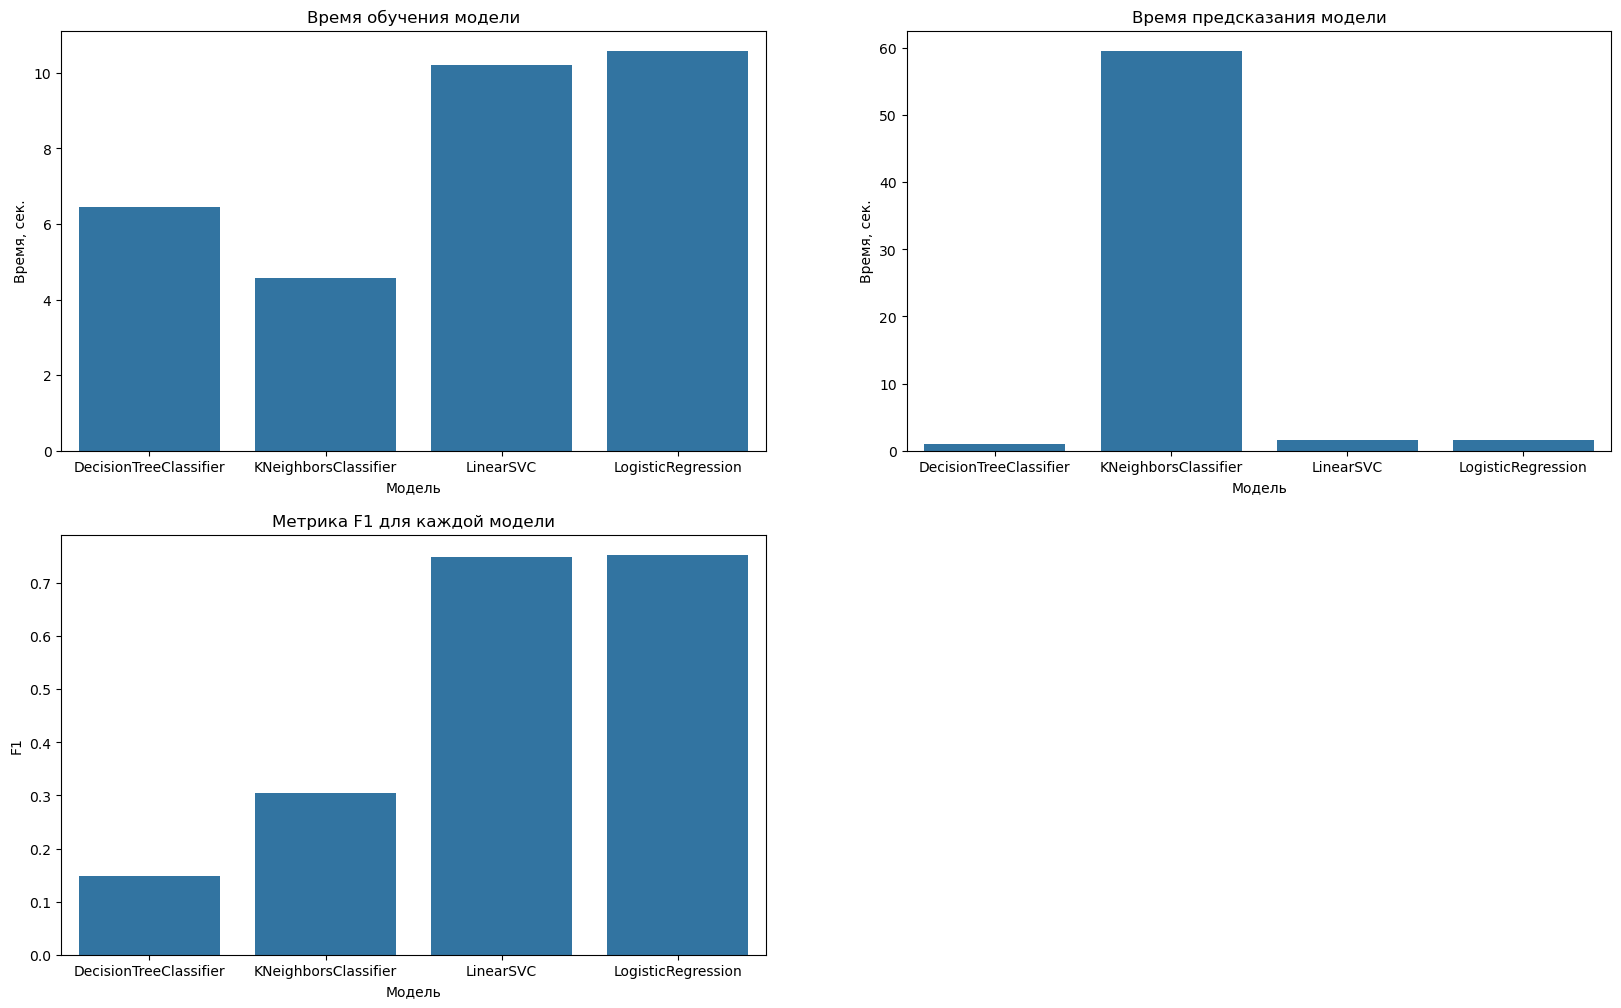

In [114]:
# Построим графики для 4-ех основных параметров для всех моделей и сравним их
#top_per_model['mean_test_score'] = -top_per_model['mean_test_score']
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
sns.barplot(data=top_per_model, x='model_name', y='mean_fit_time', ax=axes[0][0]).set(title='Время обучения модели', xlabel='Модель', ylabel='Время, сек.')
sns.barplot(data=top_per_model, x='model_name', y='mean_score_time', ax=axes[0][1]).set(title='Время предсказания модели', xlabel='Модель', ylabel='Время, сек.')
sns.barplot(data=top_per_model, x='model_name', y='mean_test_score', ax=axes[1][0]).set(title='Метрика F1 для каждой модели', xlabel='Модель', ylabel='F1');
fig.delaxes(axes[1][1])

Рейтинг моделей:
1. LinearSVC

- Время обучения - 7.58 сек
- Время предсказания - 0.03 сек
- F1 на кросс-валидации - 0.756


2. LogisticRegression

- Время обучения - 9.39 сек
- Время предсказания - 0.01 сек
- F1 на кросс-валидации - 0.755


3. KNeighborsClassifier

- Время обучения - 0.12 сек
- Время предсказания - 98.33 сек
- F1 на кросс-валидации - 0.288


4. DecisionTreeClassifier

- Время обучения - 0.32 сек
- Время предсказания - 0.05 сек
- F1 на кросс-валидации - 0.185

Как видно из полученных результатов выше, самой оптимальной моделью с точи зрения времени и точности прогноза является модель LinearSVC.

Применим ее на тестовых данных.

### Проверим лучшую модель на тестовой выборке

In [119]:
# Проверим работу модели на тестовой выборке
# Рассчитаем прогноз на тестовых данных
y_test_pred_one = randomized_search.predict(X_test)  
print(f'Метрика F1 на тестовой выборке при использовании лучшей модели: {f1_score(y_test, y_test_pred_one)}')

### Сравним результаты лучшей модели с прогнозированием DummyClassifier

In [124]:
dummy_clf = DummyClassifier(strategy="constant", constant=1)
dummy_clf.fit(X_train, y_train)
y_dummy = dummy_clf.predict(X_test)
print(f'Метрика F1 на тестовой выборке при использовании DummyClassifier: {f1_score(y_test, y_dummy)}')

Как видно из полученных результатов выше, модель LinearSVC предсказывает значения лучше, чем DummyClassifier.

## Улучшим метрику моделей

**Создадим функцию для перебора порога классификации**

In [133]:
# Функция для перебора порога классификации
def get_best_threshold(probabilities_one_valid):
    # Зададим стартовые метрики
    best_f1 = 0
    best_threshold = 0

    for threshold in np.arange(0.1, 0.9, 0.1):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(y_valid, predicted_valid)
        if (f1 > best_f1):
            best_f1 = f1
            best_threshold = threshold
            if (best_threshold >= 0.1):
                min_boundary = (best_threshold - 0.05)
                max_boundary = (best_threshold + 0.05)
                for updated_threshold in np.arange(min_boundary, max_boundary, 0.01):
                    predicted_valid = probabilities_one_valid > updated_threshold
                    f1 = f1_score(y_valid, predicted_valid)
                    if (f1 > best_f1):
                        best_f1 = f1
                        best_threshold = updated_threshold

    return [best_f1, best_threshold]

In [135]:
# Функция для поиска ближайшего значения
def find_nearest_num(ar_for_search, val):
    idx = np.abs(ar_for_search - val).argmin()
    return ar_for_search.flat[idx]

In [137]:
# Функция для отрисовки ROC-кривой
def draw_graph_roc_curve(lst_with_old_f1_and_threshold, probabilities_one_valid, model_name):

    model_name = model_name
    max_val_tpr = 0
    min_val_fpr = 0
    best_f1 = lst_with_old_f1_and_threshold[2]
    best_threshold = lst_with_old_f1_and_threshold[1]
    old_f1 = lst_with_old_f1_and_threshold[0]
    auc_roc = roc_auc_score(y_valid, probabilities_one_valid)
    fpr, tpr, all_thresholds = roc_curve(y_valid, probabilities_one_valid)
    nearest_num = find_nearest_num(all_thresholds, best_threshold)
    a = np.where(all_thresholds == nearest_num)
    index = int(a[0])
    max_val_tpr = list(tpr)[index]
    min_val_fpr = list(fpr)[index]
    plt.figure(figsize=[15,12])
    sns.set_style('darkgrid')
    plt.plot([0,1],[0,1], linestyle ='--', label='Константная модель')
    plt.text((min_val_fpr + 0.02), (max_val_tpr + 0.02),
            f'THRESHOLD - {best_threshold:.2f}, FPR - {min_val_fpr:.2f}, TPR - {max_val_tpr:.2f}',
            color='r',
            fontsize=16)
    plt.plot(fpr, tpr, color='b', label='ROC-кривая')
    plt.plot([min_val_fpr], [max_val_tpr],
             'o',
             color='r',
             label=f'Порог классификации - {best_threshold}', markersize=15)
    plt.axvline(x=min_val_fpr, color='r', linestyle='--')
    plt.axhline(y=max_val_tpr, color='r', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR', fontsize=15)
    plt.ylabel('TPR', fontsize=15)
    plt.figtext((min_val_fpr + 0.2), (max_val_tpr - 0.10), f'OLD_F1={old_f1:.2f}, NEW_F1={best_f1:.2f}, AUC_ROC={auc_roc:.2f}', fontsize=17)
    plt.title(f'ROC-Кривая для {model_name}', fontsize=17)
    plt.grid(True)
    plt.legend(edgecolor='r')
    plt.show();  

**Улучшим модель LinearSVC**

In [140]:
best_model = randomized_search.best_estimator_
clf = CalibratedClassifierCV(best_model, cv='prefit')
clf.fit(X_train, y_train)
prob_valid_lsvc = clf.predict_proba(X_valid)
prob_one_valid_lsvc = prob_valid_lsvc[:,1]

In [142]:
best_valid_f1, best_threshold_lr = get_best_threshold(prob_one_valid_lsvc)

In [144]:
best_model_param = randomized_search.best_params_

In [146]:
best_model_param.update(best_threshold=best_threshold_lr)

In [148]:
%%time
best_model_param.update(test_f1=best_valid_f1)

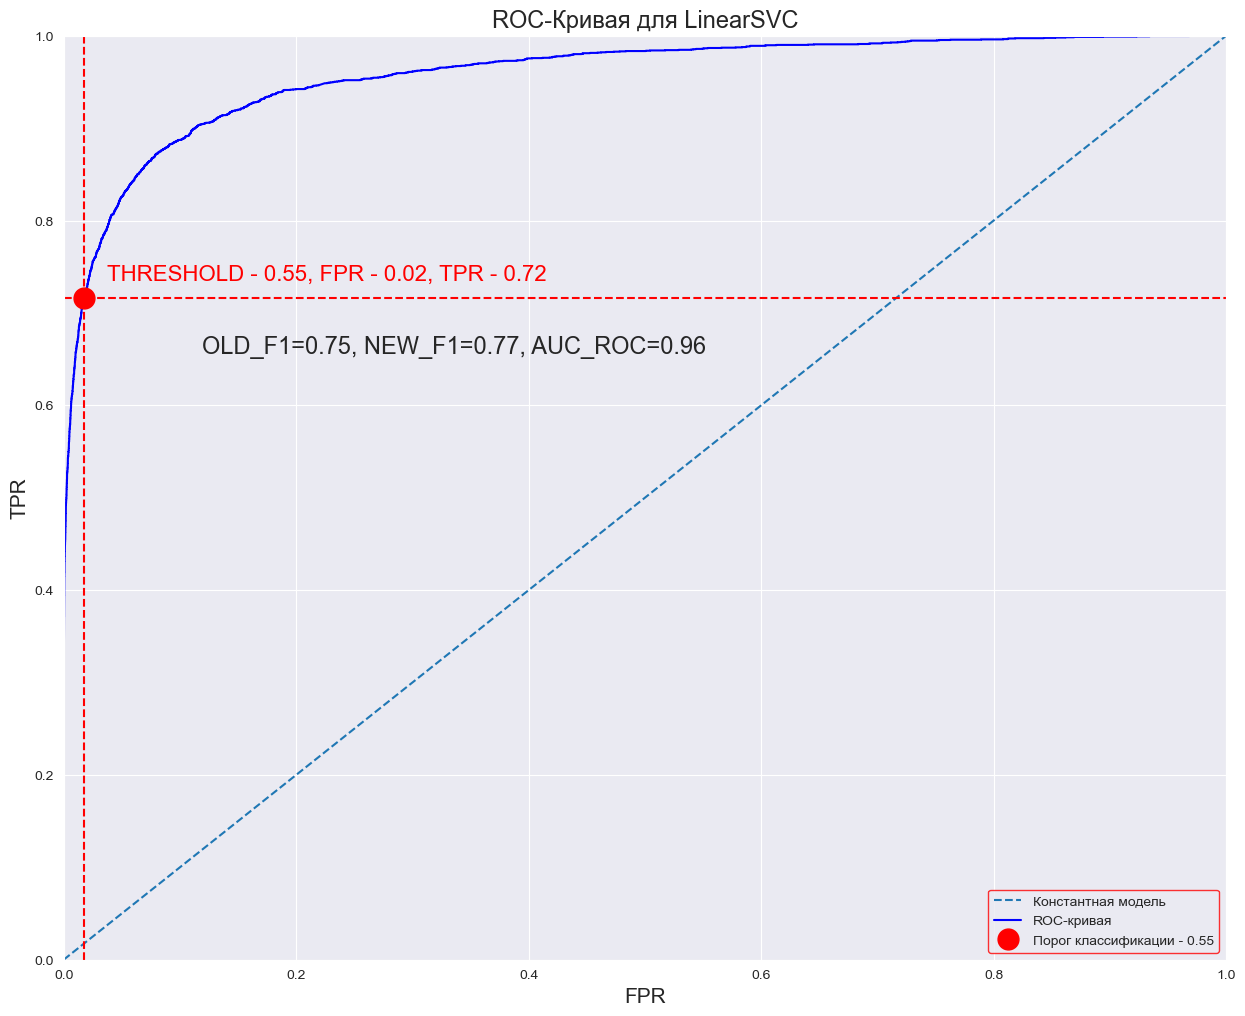

In [150]:
old_f1_valid_lr = f1_score(y_valid, randomized_search.predict(X_valid))
draw_graph_roc_curve([old_f1_valid_lr, best_threshold_lr, best_valid_f1], prob_one_valid_lsvc, 'LinearSVC')

Как видно из полученных результатов выше, самым оптимальным порогом с точки зрения метрики F1 является значение threshold = 0.55

## Обучение моделей с использованием BERT

### Подготовим данные для BERT

**Выполним преобработку текста**

In [160]:
# Функция для сокращения текста до 512 слов
def reduction_text(text):
    text = text.apply(lambda x: x.split()[:512])
    text = text.apply(" ".join)
    return text

In [162]:
%%time
df_tox_com['reduc_text'] = reduction_text(df_tox_com['text'])

In [164]:
%%time
# Выберем 2000 случайных строк
index = np.random.choice(df_tox_com.shape[0], size=2000, replace=False)
df_tox_com_sample = df_tox_com.loc[index, :]
df_tox_com_sample = df_tox_com_sample.reset_index(drop=True)

In [166]:
%%time
# Инициализируем токенизатор
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")

# Токенизируем текст
tokenized = df_tox_com_sample['reduc_text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True,truncation=True))

In [168]:
# Найдем длину самого длинного комментария
max_len = 0

for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

In [170]:
max_len

In [172]:
# Применим padding к векторам
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
# Создадим маску для важных токенов
attention_mask = np.where(padded != 0, 1, 0)

In [174]:
# Инициализируем модель класса BertModel
model = transformers.BertModel.from_pretrained("bert-base-uncased")

In [176]:
%%time
# Разобьем исходный датафрейм на батчи
batch_size = 100
# Сделаем пустой список для хранения эмбеддингов твитов
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    # Преобразуем данные
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    # Преобразуем маску
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    # Преобразуем элементы методом numpy() к типу numpy.array
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

In [181]:
features = np.concatenate(embeddings)
features = pd.DataFrame(features)

In [183]:
features

**Разобьем данные на обучающие, валидационные и тестовые**

In [205]:
X = features
y = df_tox_com_sample['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=RANDOM_STATE)

In [207]:
# Вывод необходимых размерностей
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

**Создадим пайплайн**

In [213]:
# Создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('models', LogisticRegression(random_state=RANDOM_STATE)) 
])

### Обучим четыре модели

In [216]:
# Переберём разные модели и варианты масштабирования
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    verbose=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

### Выберем лучшую модель

In [219]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика F1 лучшей модели на кросс-валидации:', randomized_search.best_score_)

## Анализ моделей с использованием BERT

### Оценим модели

In [223]:
# Сохраним 10 лучших результатов в датафрейм и выведим на экран
all_results = pd.DataFrame(randomized_search.cv_results_)
all_results = all_results.sort_values(by='rank_test_score')
all_results = all_results.reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
all_results[['param_models', 'rank_test_score', 'mean_test_score','params']]

In [225]:
# Выберем лучшие варианты для 4-ех разных моделей
results = pd.DataFrame(randomized_search.cv_results_)
results['model_name'] = results['param_models'].apply(lambda x: x.__class__.__name__)
top_per_model = results.groupby('model_name').apply(lambda x: x.nlargest(1, 'mean_test_score'))
top_per_model

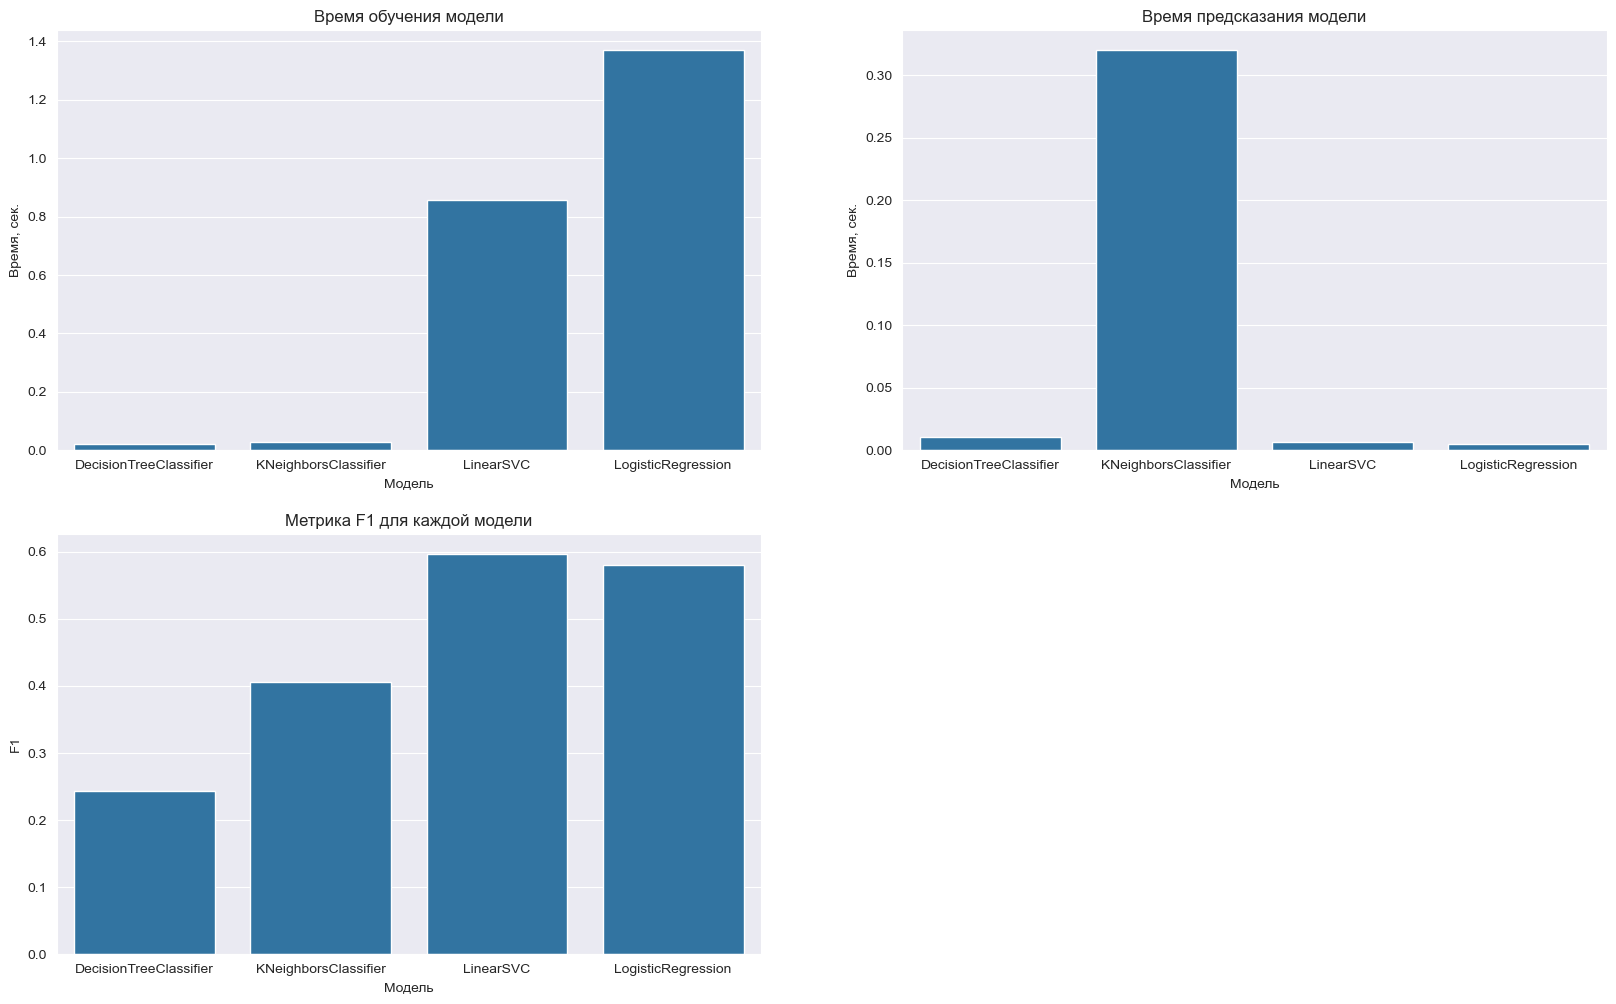

In [227]:
# Построим графики для 4-ех основных параметров для всех моделей и сравним их
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
sns.barplot(data=top_per_model, x='model_name', y='mean_fit_time', ax=axes[0][0]).set(title='Время обучения модели', xlabel='Модель', ylabel='Время, сек.')
sns.barplot(data=top_per_model, x='model_name', y='mean_score_time', ax=axes[0][1]).set(title='Время предсказания модели', xlabel='Модель', ylabel='Время, сек.')
sns.barplot(data=top_per_model, x='model_name', y='mean_test_score', ax=axes[1][0]).set(title='Метрика F1 для каждой модели', xlabel='Модель', ylabel='F1');
fig.delaxes(axes[1][1])

Рейтинг моделей:
1. LogisticRegression

- Время обучения - 1.11 сек
- Время предсказания - 0.004 сек
- F1 на кросс-валидации - 0.611


2. LinearSVC

- Время обучения - 0.56 сек
- Время предсказания - 0.007 сек
- F1 на кросс-валидации - 0.601


3. KNeighborsClassifier

- Время обучения - 0.01 сек
- Время предсказания - 0.157 сек
- F1 на кросс-валидации - 0.535


4. DecisionTreeClassifier

- Время обучения - 0.02 сек
- Время предсказания - 0.01 сек
- F1 на кросс-валидации - 0.267

### Проверим лучшую модель на тестовой выборке

In [231]:
# Проверим работу модели на тестовой выборке
# Рассчитаем прогноз на тестовых данных
y_test_pred_one = randomized_search.predict(X_test)  
print(f'Метрика F1 на тестовой выборке при использовании лучшей модели: {f1_score(y_test, y_test_pred_one)}')

In [237]:
### Сравним результаты лучшей модели с прогнозированием DummyClassifier

dummy_clf = DummyClassifier(strategy="constant", constant=1)
dummy_clf.fit(X_train, y_train)
y_dummy = dummy_clf.predict(X_test)
print(f'Метрика F1 на тестовой выборке при использовании DummyClassifier: {f1_score(y_test, y_dummy)}')

## Общий вывод

**В процессе исследования, мы:**

**1. Выгрузили исходные данные в 1 датафрейм**

**2. Предобработали данные - выставили корректные типы данных, проверили данные на наличие пропусков**

**3. Провели исследовательский анализ данных**

По полученным данным, можно сделать несколько выводов:
- 90% комментариев не являются токсичными

**4. Собрали пайплайн, обучили и сделали прогноз для 4-ех моделей**

Наилучший результат показала модель:
- LinearSVC с параметрами C=0.6

Рейтинг моделей:
1. LinearSVC

- Время обучения - 7.58 сек
- Время предсказания - 0.03 сек
- F1 на кросс-валидации - 0.756


2. LogisticRegression

- Время обучения - 9.39 сек
- Время предсказания - 0.01 сек
- F1 на кросс-валидации - 0.755


3. KNeighborsClassifier

- Время обучения - 0.12 сек
- Время предсказания - 98.33 сек
- F1 на кросс-валидации - 0.288


4. DecisionTreeClassifier

- Время обучения - 0.32 сек
- Время предсказания - 0.05 сек
- F1 на кросс-валидации - 0.185

**5. Выбрали лучшую модель и проверили ее на тестовых данных**

- Метрика F1 на тестовой выборке при использовании лучшей модели: 0.761

Сравнили работу лучшей модели с моделью DummyClassifier:
- Метрика F1 на тестовой выборке при прогнозировании DummyClassifier: 0.0